In [1]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import random 
import numpy as np
import warnings
import tensorflow as tf 
from preprocess_days_stats import preprocess_cumulative_stats, preprocess_match_days
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from preprocess_features import preprocess_columns, preprocess_columns_with_odds
from tensorflow.keras import layers
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams, plot_loss_curve
from imblearn.over_sampling import RandomOverSampler

# Ignora tutti i warning temporaneamente
warnings.filterwarnings("ignore")


df_giornate = preprocess_match_days(r"c:\Users\Hp\Documents\Serie_A_dump\csv_serie_a")
df_giornate

Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv
Reading file: I1 (18).csv
Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
preprocessing finished!


,div,giornata,stagione,date,hometeam,awayteam,ft_home_goals,ft_away_goals,ft_result,ht_home_goals,...,away_fouls,home_corners,away_corners,home_yellow,away_yellow,home_red,away_red,home_win_odds,draw_odds,away_win_odds
0,I1,1,2005/2006,2005-08-27,Fiorentina,Sampdoria,2.0,1.0,H,2.0,...,23.0,9.0,3.0,1.0,4.0,0.0,0.0,2.20,2.87,3.25
1,I1,1,2005/2006,2005-08-27,Livorno,Lecce,2.0,1.0,H,1.0,...,21.0,9.0,2.0,2.0,3.0,0.0,0.0,1.90,2.90,4.00
2,I1,1,2005/2006,2005-08-28,Ascoli,Milan,1.0,1.0,D,0.0,...,16.0,0.0,5.0,2.0,1.0,0.0,0.0,7.50,3.75,1.40
3,I1,1,2005/2006,2005-08-28,Inter,Treviso,3.0,0.0,H,1.0,...,20.0,6.0,1.0,1.0,3.0,0.0,0.0,1.16,5.50,13.00
4,I1,1,2005/2006,2005-08-28,Juventus,Chievo,1.0,0.0,H,1.0,...,12.0,6.0,2.0,1.0,2.0,0.0,0.0,1.25,5.00,13.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6955,I1,12,2023/2024,2023-11-12,Fiorentina,Bologna,2.0,1.0,H,1.0,...,15.0,0.0,3.0,2.0,2.0,0.0,0.0,2.00,3.40,3.80
6956,I1,12,2023/2024,2023-11-12,Inter,Frosinone,2.0,0.0,H,1.0,...,16.0,9.0,4.0,0.0,1.0,0.0,0.0,1.18,8.00,13.00
6957,I1,12,2023/2024,2023-11-12,Lazio,Roma,0.0,0.0,D,0.0,...,13.0,4.0,1.0,3.0,4.0,0.0,0.0,3.00,3.00,2.63
6958,I1,12,2023/2024,2023-11-12,Napoli,Empoli,0.0,1.0,A,0.0,...,13.0,8.0,3.0,1.0,1.0,0.0,0.0,1.22,7.00,11.00


# Capiamo la precisione da battere

In [190]:
conditions_1 = [
      ( (df_giornate[f'home_win_odds'] <= df_giornate['draw_odds']) & (df_giornate[f'home_win_odds'] <= df_giornate[f'away_win_odds'] )), 
      ( (df_giornate['draw_odds'] <= df_giornate[f'away_win_odds']) & (df_giornate['draw_odds'] <= df_giornate[f'home_win_odds'] )), 
      ( (df_giornate[f'away_win_odds'] <= df_giornate['draw_odds']) & (df_giornate[f'away_win_odds'] <= df_giornate[f'home_win_odds'] ))
      ]
values=['H','D','A']

precision = len(np.select(conditions_1, values)[df_giornate[f'ft_result']==np.select(conditions_1, values)])/len(df_giornate) 
precision

0.5451149425287356

La precisione da battere è 55.6%

# Salviamo i risultati della baseline in un csv

In [191]:
import csv

# Nome del file CSV
nome_file = "results/baseline_KNN.csv"

# Apri il file CSV in modalità scrittura
with open(nome_file, mode='w', newline='') as file_csv:
    # Creazione dell'oggetto writer
    writer = csv.writer(file_csv)

    # Scrivi l'intestazione nel file CSV
    writer.writerow(['giorni_cumulativi', 'vanumero_colonne', 'oversample', 'vicini', 'val_accuracy', 'train_accuracy'])

# KNN baseline

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from preprocess_features import preprocess_columns

for giorni_cumulativi in range(10):
    giorni_cumulativi = giorni_cumulativi+1
    df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)
    for numero_colonne in ['all','less','few']:    
        for oversample in [True, False]:
            (X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=oversample)

            best_accuracy=0
            for vicini in range(3,40): #prendiamo diversi numeri di vicini possibili
                knn_model = KNeighborsClassifier(n_neighbors=3*vicini) #addestriamo il modello con questo numero di vicini 
                knn_model.fit(X_train_norm, Train_labels_encoded) 
                y_valid = knn_model.predict(X_valid_norm)
                val_accuracy = round(accuracy_score(Valid_labels_encoded, y_valid),2)
                y_train = knn_model.predict(X_train_norm)
                train_accuracy = round(accuracy_score(Train_labels_encoded, y_train),2)

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    
                    # Scrivi i dati nel file CSV
                    with open(nome_file, mode='a', newline='') as file_csv:
                        writer = csv.writer(file_csv)
                        writer.writerow([giorni_cumulativi, numero_colonne, oversample, vicini*3, val_accuracy, train_accuracy])            

In [ ]:
baseline_KNN_df = pd.read_csv(r'results/baseline_KNN.csv').sort_values(['oversample','val_accuracy'],ascending=[False,False])
baseline_KNN_df.head(8)

,giorni_cumulativi,vanumero_colonne,oversample,vicini,val_accuracy,train_accuracy
362,10,less,True,105,0.47,0.47
7,1,all,True,99,0.46,0.47
19,1,less,True,78,0.46,0.48
31,1,few,True,60,0.46,0.49
126,4,less,True,114,0.46,0.46
303,9,all,True,84,0.46,0.47
345,10,all,True,81,0.46,0.48
6,1,all,True,72,0.45,0.47


In [ ]:
baseline_KNN_df = pd.read_csv(r'results/baseline_KNN.csv').sort_values(['oversample','val_accuracy'],ascending=[True,False])
baseline_KNN_df.head(8)

,giorni_cumulativi,vanumero_colonne,oversample,vicini,val_accuracy,train_accuracy
36,1,few,False,45,0.51,0.52
203,6,less,False,105,0.51,0.51
26,1,less,False,84,0.50,0.51
35,1,few,False,39,0.50,0.52
48,2,all,False,72,0.50,0.51
59,2,less,False,42,0.50,0.51
81,3,all,False,114,0.50,0.50
143,4,few,False,96,0.50,0.50


# Dense neural network

In [ ]:
import tensorflow as tf 

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            monitor='val_loss',
                                            save_best_only=True) # save only the best model to file

## Iniziamo con poche features e 3 giorni cumulativi

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

In [228]:
def create_and_compile_dense(num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                              other_num_neurons, input_shape, first_activation='relu', other_activations='relu'):

    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(first_num_neurons, activation=first_activation)(inputs)
    x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
    for i in range(num_dense_layers-1):
        x = layers.Dense(other_num_neurons, activation=other_activations)(x)
        x = layers.Dropout(other_dropouts)(x) 
    outputs = layers.Dense(3, activation='softmax')(x)
    dense_model = tf.keras.Model(inputs, outputs, name='model_1_dense')

    # compilo il modello 
    dense_model.compile(
        loss='sparse_categorical_crossentropy',
        metrics = 'accuracy',
        optimizer = tf.keras.optimizers.Adam()
    )

    return dense_model

In [ ]:
for giorni_cumulativi in [5]:
    # calcolo il dataframe con i giorni cumulativi 
    df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)
    print(f'giorni cumulativi: {giorni_cumulativi}')
    # seleziono il numero di features da usare nel modello 
    for numero_colonne in ['all','less','few']:
        print(f'numero colonne: {numero_colonne}')    
        X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded = preprocess_columns(
            df_Serie_A_days,numero_colonne,giorni_cumulativi)
        input_shape = X_train_norm.shape[1]
        # fast preprocessing 
        X_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
        X_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
        X_train_norm = X_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
        X_valid_norm = X_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
        #iniziamo a creare i modelli 
        for num_dense_layers in [2,3,4]:
            for first_dropout in [0.0, 0.2, 0.4, 0.6]:
                for other_dropouts in [0.0, 0.2, 0.4, 0.6]:
                    for first_num_neurons in [32,64,128]:
                        for other_num_neurons in [8, 16, 32]:
                            other_activations = 'relu'
                            first_activation = 'relu'
                            model_1 = create_and_compile_dense(num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                    other_num_neurons, input_shape, first_activation, other_activations)

                                # fitto il modello 
                            model_1.fit(
                                    x = X_train_norm,
                                    epochs = 15,
                                    verbose=0,
                                    validation_data = X_valid_norm,
                                    callbacks = [
                                        CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                                                    other_num_neurons, first_activation, other_activations), 
                                        #create_model_checkpoint(model_name= 'Dense_model_best')
                                                ] 
                                )

preprocess finished
giorni cumulativi: 5
numero colonne: all
utilizzando tutte le features
numero colonne: less
utilizzando meno features
numero colonne: few
utilizzando poche features


In [ ]:
df_results_5_days = pd.read_csv(r'C:\Users\Hp\Serie_A\results_5_days.csv', header=None)
df_results_1_2_4 = pd.read_csv(r'C:\Users\Hp\Serie_A\results_1_2_4.csv', header=None)
df_results =pd.concat([df_results_5_days,df_results_1_2_4],ignore_index=True)
df_results.columns = ['experiment', 'num_dense_layers', 'first_dropout', 'other_dropouts', 'first_num_neurons',
                                    'other_num_neurons', 'first_activation', 'other_activations', 'epoch',
                                    'loss', 'accuracy','val_loss','val_accuracy']
df_results.sort_values(['val_loss'], inplace=True)
df_results.head(3)

,experiment,num_dense_layers,first_dropout,other_dropouts,first_num_neurons,other_num_neurons,first_activation,other_activations,epoch,loss,accuracy,val_loss,val_accuracy
22671,model_1_dense,3,0.2,0.0,32,8,relu,relu,13,0.960349,0.539939,0.982211,0.535714
22670,model_1_dense,3,0.2,0.0,32,8,relu,relu,11,0.969211,0.537220,0.982554,0.537088
22669,model_1_dense,3,0.2,0.0,32,8,relu,relu,10,0.968809,0.538409,0.983473,0.535714


### il modello denso migliore 

giorni =5, colonne = less, val_loss: 0.9921 - val_accuracy: 0.5247

giorni = 2, colonne = few, val_loss: 0.9895 - val_accuracy: 0.5220

In [245]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 2
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm))
Train_labels_encoded = tf.data.Dataset.from_tensor_slices(Train_labels_encoded) # make labels
Dataset_train_norm = tf.data.Dataset.zip((Dataset_train_norm, Train_labels_encoded))

Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm))
Valid_labels_encoded = tf.data.Dataset.from_tensor_slices(Valid_labels_encoded) # make labels
Dataset_valid_norm = tf.data.Dataset.zip((Dataset_valid_norm, Valid_labels_encoded))

Dataset_test_norm = tf.data.Dataset.from_tensor_slices((X_test_norm))
Test_labels_encoded = tf.data.Dataset.from_tensor_slices(Test_labels_encoded) # make labels
Dataset_test_norm = tf.data.Dataset.zip((Dataset_test_norm, Test_labels_encoded))

Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
Dataset_test_norm = Dataset_test_norm.batch(32).prefetch(tf.data.AUTOTUNE)

#creo e compilo il modello 
model_1 = create_and_compile_dense(num_dense_layers=3, first_dropout=0.2, other_dropouts=0.1, first_num_neurons=32,
                            other_num_neurons=8, input_shape=input_shape, first_activation='relu', other_activations='relu')

# fitto il modello 
history_1 = model_1.fit(
                x = Dataset_train_norm,
                epochs = 15,
                verbose = 1,
                batch_size = 128,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                #                other_num_neurons, first_activation, other_activations), 
                                #create_model_checkpoint(model_name= 'Dense_model_best') 
                            ] 
                )

preprocess finished
numero colonne: less
utilizzando meno features
Epoch 1/15
184/184 [==============================] - 2s 4ms/step - loss: 1.0690 - accuracy: 0.4373 - val_loss: 1.0488 - val_accuracy: 0.4629
Epoch 2/15
184/184 [==============================] - 0s 2ms/step - loss: 1.0404 - accuracy: 0.4562 - val_loss: 1.0303 - val_accuracy: 0.4821
Epoch 3/15
184/184 [==============================] - 1s 3ms/step - loss: 1.0231 - accuracy: 0.4976 - val_loss: 1.0089 - val_accuracy: 0.5027
Epoch 4/15
184/184 [==============================] - 1s 3ms/step - loss: 1.0051 - accuracy: 0.5190 - val_loss: 0.9978 - val_accuracy: 0.5055
Epoch 5/15
184/184 [==============================] - 0s 2ms/step - loss: 0.9882 - accuracy: 0.5252 - val_loss: 0.9929 - val_accuracy: 0.5206
Epoch 6/15
184/184 [==============================] - 0s 2ms/step - loss: 0.9855 - accuracy: 0.5325 - val_loss: 0.9889 - val_accuracy: 0.5220
Epoch 7/15
184/184 [==============================] - 1s 3ms/step - loss: 0.9751 

### VAlutiamo il modello

In [ ]:
model_1 = tf.keras.models.load_model(r'C:\Users\Hp\Serie_A\model_experiments\Dense_model_best')
model_1.evaluate(Dataset_valid_norm)

ValueError: in user code:

    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\keras\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1_dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 131) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 3) dtype=float64>]


0

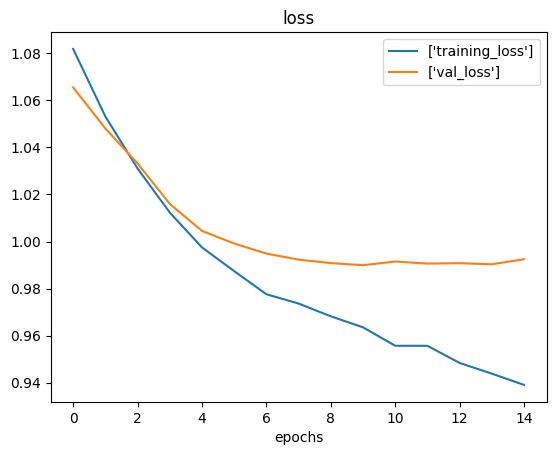

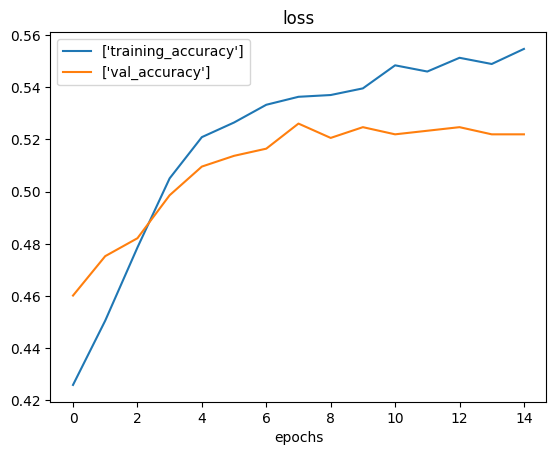

In [ ]:
plot_loss_curve(history_1)

Si nota un po' di overfitting nel nostro modelo

In [ ]:
result_df = pd.merge(X_valid_df, df_giornate, how='inner', on=['stagione', 'awayteam','hometeam']).reset_index()
len(result_df), len(result_df['stagione'])

(728, 728)

In [ ]:
# Visualizziamo un po' di risultati 
model_1_pred_probs = model_1.predict(X_valid_norm)
model_1_prob = model_1.predict(X_valid_norm).max(axis=1)
model_1_predictions = model_1_pred_probs.argmax(axis=1)
model_1_compare = pd.DataFrame({
                                'stagione': list( result_df['stagione'] ),
                                'hometeam': list( result_df['hometeam'] ),
                                'awayteam': list( result_df['awayteam'] ),
                                'preds': model_1_predictions, 
                                'result': Valid_labels, 
                                'pred_prob': model_1_prob,
                                'home_win_odds': list( result_df['home_win_odds'] ),
                                'draw_odds': list( result_df['draw_odds'] ),
                                'away_win_odds': list( result_df['away_win_odds'])
                                })
model_1_compare['snai_pred'] = np.argmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_1_compare['snai_prob'] = np.nanmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assegno ai valori encoded dei valori più comprensibili per vittoria pareggio sconfitta
conditions = [
(model_1_compare['preds'] == 2),  # Condizione per Home Win
(model_1_compare['preds'] == 1),  # Condizione per Away Win
(model_1_compare['preds'] == 0)   # Condizione per Draw
]
conditions_snai = [
(model_1_compare['snai_pred'] == 0),  # Condizione per Home Win
(model_1_compare['snai_pred'] == 2),  # Condizione per Away Win
(model_1_compare['snai_pred'] == 1)   # Condizione per Draw
]

# Valori corrispondenti alle condizioni
values = ['W', 'L', 'D']

# Creazione della nuova colonna 'result' e 'points
model_1_compare['preds'] = np.select(conditions, values)
model_1_compare['snai_pred'] = np.select(conditions_snai, values)
model_1_compare['is_correct'] = model_1_compare['preds'] == model_1_compare['result']

len(model_1_compare)

23/23 [==============================] - 0s 864us/step


728

In [ ]:
# Visualizziamo i risultati più regenti 
model_1_compare.sort_values(['stagione'], ascending = False).head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
6897,2023/2024,Frosinone,Fiorentina,L,D,0.398243,3.75,3.60,1.95,L,1.95,False
6932,2023/2024,Lecce,Torino,L,L,0.427992,2.75,3.00,2.80,W,2.75,True
6871,2023/2024,Inter,Milan,W,W,0.517370,2.15,3.50,3.40,W,2.15,True
6884,2023/2024,Sassuolo,Juventus,L,W,0.600415,4.00,4.00,1.80,L,1.80,False
6845,2023/2024,Roma,Salernitana,W,D,0.630786,1.53,4.00,6.50,W,1.53,False
6913,2023/2024,Inter,Bologna,W,D,0.657057,1.36,5.50,7.50,W,1.36,False
6886,2023/2024,Bologna,Napoli,L,D,0.486598,3.75,3.60,1.91,L,1.91,False
6903,2023/2024,Atalanta,Juventus,L,D,0.477075,2.50,3.40,2.80,W,2.50,False
6896,2023/2024,Verona,Atalanta,L,L,0.472274,4.20,3.75,1.83,L,1.83,True
6875,2023/2024,Frosinone,Sassuolo,L,W,0.359327,2.80,3.40,2.50,L,2.50,False


In [ ]:
# Visualizziamo i nostri riusltati corretti e quelli sbagliati della snai 
model_1_compare[(model_1_compare['is_correct']) & (model_1_compare['result']!=model_1_compare['snai_pred'])].head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
6353,2021/2022,Napoli,Milan,L,L,0.356057,2.05,3.30,3.60,W,2.05,True
5964,2020/2021,Milan,Napoli,L,L,0.358076,2.55,3.30,2.80,W,2.55,True
2211,2010/2011,Udinese,Roma,L,L,0.465828,2.20,3.20,3.40,W,2.20,True
2361,2011/2012,Inter,Juventus,L,L,0.416441,2.50,3.20,2.88,W,2.50,True
413,2006/2007,Empoli,Palermo,W,W,0.373913,3.10,3.00,2.40,L,2.40,True
5623,2019/2020,Bologna,Sassuolo,L,L,0.379678,2.25,3.50,3.00,W,2.25,True
3859,2015/2016,Frosinone,Empoli,W,W,0.420594,3.00,3.30,2.40,L,2.40,True
1372,2008/2009,Atalanta,Roma,W,W,0.454483,3.60,3.25,2.10,L,2.10,True
4536,2016/2017,Palermo,Genoa,W,W,0.466695,5.00,4.00,1.67,L,1.67,True
6549,2022/2023,Fiorentina,Lazio,L,L,0.435927,2.40,3.50,2.80,W,2.40,True


In [ ]:
# visualizziamo i risultati più sbagliati
model_1_compare[(~model_1_compare['is_correct'])].sort_values(['pred_prob'], ascending=False).head(10)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct
362,2005/2006,Inter,Siena,W,D,0.810917,1.40,4.00,9.00,W,1.40,False
1794,2009/2010,Juventus,Siena,W,D,0.803054,1.36,4.50,9.00,W,1.36,False
2236,2010/2011,Juventus,Catania,W,D,0.799998,1.44,4.20,7.50,W,1.44,False
2177,2010/2011,Napoli,Brescia,W,D,0.788951,1.36,4.33,10.00,W,1.36,False
624,2006/2007,Inter,Udinese,W,D,0.781283,1.33,4.50,9.50,W,1.33,False
1105,2007/2008,Napoli,Siena,W,D,0.775727,1.95,2.75,5.25,W,1.95,False
4479,2016/2017,Inter,Sampdoria,W,L,0.771817,1.33,5.50,9.00,W,1.33,False
6754,2022/2023,Napoli,Verona,W,D,0.762938,1.53,4.00,6.50,W,1.53,False
1350,2008/2009,Juventus,Cagliari,W,L,0.755631,1.36,4.50,9.00,W,1.36,False
6294,2021/2022,Milan,Spezia,W,L,0.742436,1.33,5.00,9.50,W,1.33,False


Si vede che molti errori sono dati da squadre blasonate che giocano in casa

# CONV1D model

In [ ]:
def create_and_compile_conv_1d(num_conv_layers, first_dropout, other_dropouts, first_filters_num, first_kernel_size,
                               other_num_filters, other_kernel_sizem, input_shape, dense_neurons, first_activation='relu', other_activations='relu'):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Conv1D(filters=first_filters_num, kernel_size=first_kernel_size, activation=first_activation)(x)
    x = layers.Dropout(first_dropout)(x) 
    for i in range(num_conv_layers-1):
        x = layers.Conv1D(filters=other_num_filters, kernel_size=other_kernel_sizem, activation=first_activation)(x)
        x = layers.Dropout(other_dropouts)(x) 
    x = layers.Flatten()(x)
    x = layers.Dense(dense_neurons)(x)
    x = layers.Dropout(other_dropouts)(x) 
    outputs = layers.Dense(3, activation='softmax')(x)
    conv_model = tf.keras.Model(inputs, outputs, name='model_1_dense')

    # compilo il modello 
    conv_model.compile(
        loss='sparse_categorical_crossentropy',
        metrics = 'accuracy',
        optimizer = tf.keras.optimizers.Adam()
    )

    return conv_model

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 3
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]

# fast preprocessing 
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_labels_encoded))
Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_labels_encoded))
Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)

#creo e compilo il modello 
model_2 = create_and_compile_conv_1d(num_dense_layers=3, first_dropout=0.2, other_dropouts=0.0,
                            other_num_neurons=8, input_shape=input_shape, first_activation='relu', other_activations='relu')

# fitto il modello 
history_2 = model_2.fit(
                x = Dataset_train_norm,
                epochs = 15,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #CSVLoggerCallbackParams('results.csv','model_1_dense', num_dense_layers, first_dropout, other_dropouts, first_num_neurons,
                                #                other_num_neurons, first_activation, other_activations), 
                                #create_model_checkpoint(model_name= 'CONV1D_model_best') 
                            ] 
                )

preprocess finished
numero colonne: less
utilizzando meno features
Epoch 1/15
184/184 [==============================] - 22s 118ms/step - loss: 1.0252 - accuracy: 0.4935 - val_loss: 1.0026 - val_accuracy: 0.5124
Epoch 2/15
184/184 [==============================] - 21s 116ms/step - loss: 0.9929 - accuracy: 0.5190 - val_loss: 1.0034 - val_accuracy: 0.5055
Epoch 3/15
184/184 [==============================] - 21s 115ms/step - loss: 0.9856 - accuracy: 0.5309 - val_loss: 1.0043 - val_accuracy: 0.5247
Epoch 4/15
184/184 [==============================] - 21s 112ms/step - loss: 0.9824 - accuracy: 0.5309 - val_loss: 1.0015 - val_accuracy: 0.5151
Epoch 5/15
184/184 [==============================] - 21s 112ms/step - loss: 0.9796 - accuracy: 0.5345 - val_loss: 1.0052 - val_accuracy: 0.5179
Epoch 6/15
184/184 [==============================] - 20s 111ms/step - loss: 0.9807 - accuracy: 0.5308 - val_loss: 1.0040 - val_accuracy: 0.5151
Epoch 7/15
184/184 [==============================] - 20s 108ms

# Unisco il modello dense che ho creato sopra con uno che tenga conto delle quote 

In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            monitor='val_loss',
                                            save_best_only=True) # save only the best model to file

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 2
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels,Train_odds_df,Valid_odds_df,Test_odds_df) = preprocess_columns_with_odds(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]

print(X_valid_norm.shape,X_test_norm.shape,len(Test_odds_df))

# fast preprocessing 
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, Train_odds_df))
Train_labels_encoded = tf.data.Dataset.from_tensor_slices(Train_labels_encoded) # make labels
Dataset_train_norm = tf.data.Dataset.zip((Dataset_train_norm, Train_labels_encoded))

Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm, Valid_odds_df))
Valid_labels_encoded = tf.data.Dataset.from_tensor_slices(Valid_labels_encoded) # make labels
Dataset_valid_norm = tf.data.Dataset.zip((Dataset_valid_norm, Valid_labels_encoded))

Dataset_Test_norm = tf.data.Dataset.from_tensor_slices((X_test_norm, Test_odds_df))
Test_labels_encoded = tf.data.Dataset.from_tensor_slices(Test_labels_encoded) # make labels
Dataset_Test_norm = tf.data.Dataset.zip((Dataset_Test_norm, Test_labels_encoded))

Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
Dataset_Test_norm = Dataset_Test_norm.batch(32).prefetch(tf.data.AUTOTUNE)

print(Dataset_valid_norm)
Dataset_Test_norm

preprocess finished
numero colonne: less
utilizzando meno features
(728, 131) (348, 131) 348
<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 131), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 131), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

#creo e compilo il modello denso
inputs = layers.Input(shape=(input_shape,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)  # Aggiunto il layer di dropout per ridurre overfitting
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.1)(x) 
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dropout(0.1)(x) 
dense_model = tf.keras.Model(inputs, outputs, name='model_3_dense')

#creo un modello che interpreti le odds
inputs_odds = layers.Input(shape=(3,))
x = layers.Dense(8, activation='relu')(inputs_odds)
outputs_odds = layers.Dense(3, activation='linear')(x)
model_3_odds = tf.keras.Model(inputs_odds, outputs_odds, name='model_3_odds')

#unisco i due modelli 
# 3. Concatenate token and char inputs 
odds_concat = layers.Concatenate(name="odds_dense_model")([model_3_odds.output,
                                                                  dense_model.output])
x = layers.Dense(16, activation='tanh')(odds_concat)
x =layers.Dropout(0.5)(x)
output_layer = layers.Dense(3, activation = 'softmax')(x)

#Costruisco il modello con char e token input
model_3 =tf.keras.Model(
    inputs=[dense_model.input, model_3_odds.input],
    outputs=output_layer,
    name='model_4_odds_concat'
)

# compilo il modello 
model_3.compile(
    loss='sparse_categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
)

#Se vuoi ridurre il tasso di apprendimento del 10% ogni 10 epoche
def scheduler(epoch, lr):
    if epoch == 5:
        return lr * 0.01  # Riduci il tasso di apprendimento del 10% ogni 10 epoche
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

# fitto il modello 
history_3 = model_3.fit(
                x = Dataset_train_norm,
                epochs = 6,
                verbose = 1,
                batch_size = 32,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                CSVLoggerCallbackParams('results.csv','model_3_dense', giorni_cumulativi,numero_colonne, 3, 0.2, 0.0, 32,
                                                8, 'relu', 'relu'), 
                                lr_scheduler,
                                create_model_checkpoint(model_name= 'Dense_model_best_1') 
                            ] 
                )

## Valuto il modello migliore

In [ ]:
model_3 = tf.keras.models.load_model(r'C:\Users\Hp\Serie_A\model_experiments\Dense_model_best_1')
model_3.evaluate(Dataset_Test_norm)

11/11 [==============================] - 0s 2ms/step - loss: 0.9666 - accuracy: 0.5431


[0.9666320085525513, 0.5431034564971924]

0

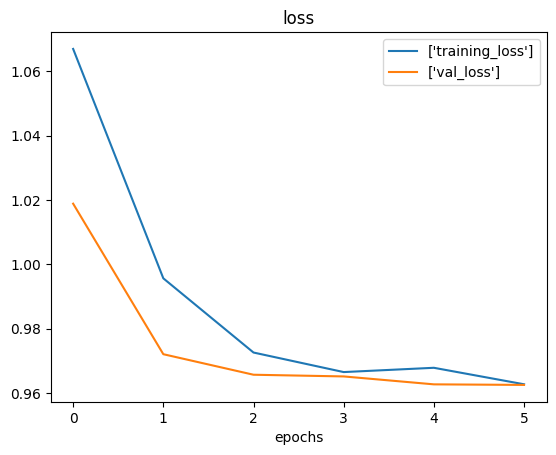

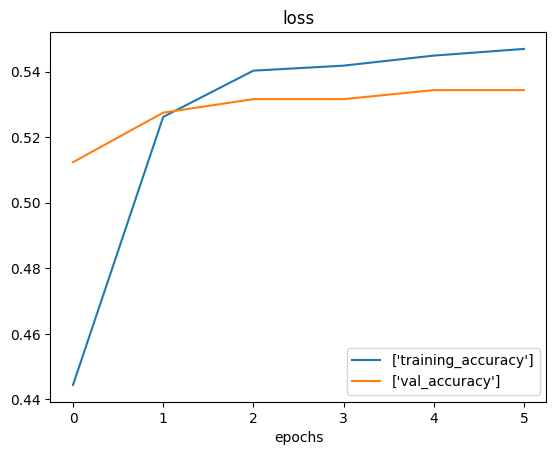

In [ ]:
plot_loss_curve(history_3)

### Vediamo come performano i nostri risultati rispetto a quelli della snai 

In [217]:
result_df = pd.merge(X_valid_df, df_giornate, how='inner', on=['stagione', 'awayteam','hometeam']).reset_index()

# Visualizziamo un po' di risultati 
model_3_pred_probs = model_3.predict((X_valid_norm, Valid_odds_df))
model_3_prob = model_3_pred_probs.max(axis=1)
model_3_predictions = model_3_pred_probs.argmax(axis=1)
model_3_compare = pd.DataFrame({
                                'stagione': list( result_df['stagione'] ),
                                'hometeam': list( result_df['hometeam'] ),
                                'awayteam': list( result_df['awayteam'] ),
                                'preds': model_3_predictions, 
                                'result': Valid_labels, 
                                'pred_prob': model_3_prob,
                                'home_win_odds': list( result_df['home_win_odds'] ),
                                'draw_odds': list( result_df['draw_odds'] ),
                                'away_win_odds': list( result_df['away_win_odds'])
                                })
model_3_compare['snai_pred'] = np.argmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_3_compare['snai_prob'] = np.nanmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assegno ai valori encoded dei valori più comprensibili per vittoria pareggio sconfitta
conditions = [
(model_3_compare['preds'] == 2),  # Condizione per Home Win
(model_3_compare['preds'] == 1),  # Condizione per Away Win
(model_3_compare['preds'] == 0)   # Condizione per Draw
]
conditions_snai = [
(model_3_compare['snai_pred'] == 0),  # Condizione per Home Win
(model_3_compare['snai_pred'] == 2),  # Condizione per Away Win
(model_3_compare['snai_pred'] == 1)   # Condizione per Draw
]

# Valori corrispondenti alle condizioni
values = ['W', 'L', 'D']

# Creazione della nuova colonna 'result' e 'points
model_3_compare['preds'] = np.select(conditions, values)
model_3_compare['snai_pred'] = np.select(conditions_snai, values)
model_3_compare['is_correct'] = model_3_compare['preds'] == model_3_compare['result']
model_3_compare['money_won'] = model_3_compare['pred_prob']*model_3_compare['snai_prob']

len(model_3_compare)

23/23 [==============================] - 0s 2ms/step


728

In [218]:
# Visualizziamo i nostri riusltati corretti e quelli sbagliati della snai
test = model_3_compare[(model_3_compare['is_correct']) & (model_3_compare['result']!=model_3_compare['snai_pred'])].sort_values(['money_won'], ascending=False).head(100)
print(f'il nostro modello ha performato meglio in {len(test)} su {len(model_3_compare)}') 
test.head()


il nostro modello ha performato meglio in 13 su 728


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
2519,2011/2012,Atalanta,Roma,W,W,0.421180,3.00,3.25,2.38,L,2.38,True,1.002408
6815,2022/2023,Napoli,Inter,W,W,0.404760,2.90,3.30,2.45,L,2.45,True,0.991663
5350,2019/2020,Cagliari,Genoa,W,W,0.378429,2.75,3.40,2.55,L,2.55,True,0.964995
4369,2016/2017,Cagliari,Genoa,W,W,0.376411,2.80,3.40,2.50,L,2.50,True,0.941027
3384,2013/2014,Cagliari,Parma,W,W,0.380568,3.00,3.25,2.38,L,2.38,True,0.905751


### IL modello sembra completamente incapace di prevedere i pareggi

In [195]:
len(model_3_compare[(model_3_compare['result']=='D')]), len(model_3_compare[(model_3_compare['result']=='D')&(model_3_compare['is_correct'])])

(180, 0)

### Vincita soldi

In [219]:
# vediamo in quanti casi avremmo vinto soldi 
test_1 = model_3_compare[(model_3_compare['is_correct']) & (model_3_compare['money_won']>1)].sort_values(['money_won'], ascending=False)
correct_results = model_3_compare[(model_3_compare['is_correct'])]
print(f'il nostro modello ha performato meglio in {len(test_1)} su {len(model_3_compare)} totali e {len(correct_results)} casi in cui la predizione è corretta ') 
test_1.head(20)

il nostro modello ha performato meglio in 110 su 728 totali e 389 casi in cui la predizione è corretta 


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
2654,2011/2012,Genoa,Palermo,W,W,0.565700,2.00,2.30,6.00,W,2.00,True,1.131400
962,2007/2008,Genoa,Catania,W,W,0.562976,2.00,2.90,4.50,W,2.00,True,1.125952
4640,2017/2018,Sampdoria,Crotone,W,W,0.717718,1.53,3.79,7.50,W,1.53,True,1.098108
2603,2011/2012,Parma,Cagliari,W,W,0.481812,2.25,2.70,4.00,W,2.25,True,1.084076
800,2007/2008,Catania,Empoli,W,W,0.456693,2.37,2.87,3.40,W,2.37,True,1.082362
288,2005/2006,Parma,Livorno,W,W,0.468151,2.30,2.87,3.40,W,2.30,True,1.076747
2234,2010/2011,Genoa,Lecce,W,W,0.485778,2.20,2.38,4.50,W,2.20,True,1.068711
2089,2010/2011,Brescia,Parma,W,W,0.427202,2.50,3.00,3.00,W,2.50,True,1.068005
208,2005/2006,Siena,Milan,L,L,0.678055,7.00,3.40,1.57,L,1.57,True,1.064546
6358,2021/2022,Spezia,Cagliari,W,W,0.404914,2.62,3.30,2.62,W,2.62,True,1.060875


In [220]:
# vediamo in quanti casi avremmo perso soldi 
test_2 = model_3_compare[(model_3_compare['money_won']>1)]
wrong_results = model_3_compare[(~model_3_compare['is_correct'])].sort_values(['money_won'], ascending=False)
test_2.head(20)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
2234,2010/2011,Genoa,Lecce,W,W,0.485778,2.20,2.38,4.50,W,2.20,True,1.068711
5377,2019/2020,Napoli,Brescia,W,W,0.813000,1.25,6.00,12.00,W,1.25,True,1.016250
2217,2010/2011,Lazio,Parma,W,W,0.604539,1.75,3.40,5.00,W,1.75,True,1.057943
2009,2010/2011,Parma,Sampdoria,W,W,0.434099,2.38,3.10,3.10,W,2.38,True,1.033155
1114,2007/2008,Lazio,Palermo,W,L,0.411627,2.50,2.50,3.80,W,2.50,False,1.029067
5908,2020/2021,Udinese,Verona,W,W,0.442112,2.30,3.10,3.30,W,2.30,True,1.016857
1403,2008/2009,Bologna,Sampdoria,W,W,0.433213,2.37,3.20,3.20,W,2.37,True,1.026716
4211,2016/2017,Napoli,Bologna,W,W,0.806836,1.25,6.00,12.00,W,1.25,True,1.008545
1727,2009/2010,Udinese,Sampdoria,W,L,0.530335,2.10,3.20,3.60,W,2.10,False,1.113704
4781,2017/2018,Sampdoria,Torino,W,D,0.504567,2.39,3.39,2.89,W,2.39,False,1.205915


In [221]:
# vediamo quanti soldi avrei vinto e quanti perso
test_1['snai_prob'].sum()-len(test_2)

12.369999999999976

## Facciamo gli stessi test sul dataset di test

In [222]:
result_df = pd.merge(X_test_df, df_giornate, how='inner', on=['stagione', 'awayteam','hometeam']).reset_index()

# Visualizziamo un po' di risultati 
model_3_pred_probs = model_3.predict((X_test_norm, Test_odds_df))
model_3_prob = model_3_pred_probs.max(axis=1)
model_3_predictions = model_3_pred_probs.argmax(axis=1)
model_3_compare = pd.DataFrame({
                                'stagione': list( result_df['stagione'] ),
                                'hometeam': list( result_df['hometeam'] ),
                                'awayteam': list( result_df['awayteam'] ),
                                'preds': model_3_predictions, 
                                'result': Test_labels, 
                                'pred_prob': model_3_prob,
                                'home_win_odds': list( result_df['home_win_odds'] ),
                                'draw_odds': list( result_df['draw_odds'] ),
                                'away_win_odds': list( result_df['away_win_odds'])
                                })
model_3_compare['snai_pred'] = np.argmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_3_compare['snai_prob'] = np.nanmin(result_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assegno ai valori encoded dei valori più comprensibili per vittoria pareggio sconfitta
conditions = [
(model_3_compare['preds'] == 2),  # Condizione per Home Win
(model_3_compare['preds'] == 1),  # Condizione per Away Win
(model_3_compare['preds'] == 0)   # Condizione per Draw
]
conditions_snai = [
(model_3_compare['snai_pred'] == 0),  # Condizione per Home Win
(model_3_compare['snai_pred'] == 2),  # Condizione per Away Win
(model_3_compare['snai_pred'] == 1)   # Condizione per Draw
]

# Valori corrispondenti alle condizioni
values = ['W', 'L', 'D']

# Creazione della nuova colonna 'result' e 'points
model_3_compare['preds'] = np.select(conditions, values)
model_3_compare['snai_pred'] = np.select(conditions_snai, values)
model_3_compare['is_correct'] = model_3_compare['preds'] == model_3_compare['result']
model_3_compare['money_won'] = model_3_compare['pred_prob']*model_3_compare['snai_prob']

11/11 [==============================] - 0s 2ms/step


In [223]:
# Visualizziamo i nostri riusltati corretti e quelli sbagliati della snai
test = model_3_compare[(model_3_compare['is_correct']) & (model_3_compare['result']!=model_3_compare['snai_pred'])].sort_values(['money_won'], ascending=False).head(100)
print(f'il nostro modello ha performato meglio in {len(test)} su {len(model_3_compare)}') 
test.head()

il nostro modello ha performato meglio in 8 su 348


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
2623,2011/2012,Atalanta,Fiorentina,W,W,0.446711,2.70,2.5,3.4,D,2.5,True,1.116778
5584,2019/2020,Spal,Cagliari,L,L,0.359046,2.70,3.2,2.7,W,2.7,True,0.969425
748,2006/2007,Sampdoria,Catania,W,W,0.371269,2.80,3.1,2.5,L,2.5,True,0.928173
2775,2012/2013,Lazio,Roma,W,W,0.364046,2.63,3.5,2.5,L,2.5,True,0.910114
3150,2013/2014,Catania,Udinese,W,W,0.352966,2.90,3.1,2.5,L,2.5,True,0.882414


In [224]:
# Visualizziamo i nostri riusltati sbagliati e quelli corretti della snai
test = model_3_compare[(~model_3_compare['is_correct']) & (model_3_compare['result']==model_3_compare['snai_pred'])].sort_values(['money_won'], ascending=False).head(100)
print(f'il nostro modello ha performato peggio in {len(test)} su {len(model_3_compare)}') 
test.head()

il nostro modello ha performato peggio in 6 su 348


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
1859,2009/2010,Udinese,Bologna,W,D,0.678733,2.10,2.00,9.50,D,2.0,False,1.357467
5845,2020/2021,Parma,Torino,W,L,0.368155,2.75,3.20,2.60,L,2.6,False,0.957203
2540,2011/2012,Chievo,Inter,W,L,0.357922,2.75,3.20,2.60,L,2.6,False,0.930597
2165,2010/2011,Cesena,Chievo,L,W,0.356667,2.60,3.00,2.88,W,2.6,False,0.927335
96,2005/2006,Reggina,Lazio,L,W,0.355138,2.60,2.87,2.60,W,2.6,False,0.923360


In [225]:
# vediamo in quanti casi avremmo vinto soldi 
test_1 = model_3_compare[(model_3_compare['is_correct']) & (model_3_compare['money_won']>1)].sort_values(['money_won'], ascending=False)
correct_results = model_3_compare[(model_3_compare['is_correct'])]
print(f'il nostro modello ha performato meglio in {len(test_1)} su {len(model_3_compare)} totali e {len(correct_results)} casi in cui la predizione è corretta ') 
test_1.head(20)

il nostro modello ha performato meglio in 41 su 348 totali e 189 casi in cui la predizione è corretta 


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
4917,2017/2018,Sassuolo,Sampdoria,W,W,0.505623,2.29,3.25,3.25,W,2.29,True,1.157877
1662,2009/2010,Bologna,Udinese,W,W,0.456387,2.50,3.20,2.88,W,2.50,True,1.140968
2623,2011/2012,Atalanta,Fiorentina,W,W,0.446711,2.70,2.50,3.40,D,2.50,True,1.116778
5828,2020/2021,Crotone,Parma,W,W,0.422890,2.62,3.40,2.62,W,2.62,True,1.107971
6533,2022/2023,Atalanta,Fiorentina,W,W,0.548336,1.95,3.50,4.00,W,1.95,True,1.069255
3581,2014/2015,Cesena,Napoli,L,L,0.783655,9.50,4.75,1.36,L,1.36,True,1.065771
2126,2010/2011,Bari,Inter,L,L,0.737642,8.00,4.00,1.44,L,1.44,True,1.062204
5974,2020/2021,Sampdoria,Torino,W,W,0.447676,2.37,3.30,3.00,W,2.37,True,1.060991
1271,2008/2009,Atalanta,Lazio,W,W,0.422583,2.50,3.00,3.00,W,2.50,True,1.056456
434,2006/2007,Inter,Catania,W,W,0.876936,1.20,5.50,17.00,W,1.20,True,1.052323


In [226]:
# vediamo in quanti casi avremmo perso soldi 
test_2 = model_3_compare[(model_3_compare['money_won']>1)]
wrong_results = model_3_compare[(~model_3_compare['is_correct'])].sort_values(['money_won'], ascending=False)
print(f'il nostro modello ha performato peggio in {len(test_2)} su {len(model_3_compare)} totali e {len(wrong_results)} casi in cui la predizione è sbagliata ') 
test_2.head(20)

il nostro modello ha performato peggio in 80 su 348 totali e 159 casi in cui la predizione è sbagliata 


,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
139,2005/2006,Udinese,Livorno,W,L,0.561348,1.80,3.00,4.33,W,1.80,False,1.010427
1914,2010/2011,Catania,Parma,W,W,0.453471,2.25,3.10,3.40,W,2.25,True,1.020310
5274,2018/2019,Frosinone,Napoli,L,L,0.776547,10.00,4.75,1.33,L,1.33,True,1.032807
1152,2008/2009,Bologna,Atalanta,W,L,0.471732,2.20,3.00,3.60,W,2.20,False,1.037810
3581,2014/2015,Cesena,Napoli,L,L,0.783655,9.50,4.75,1.36,L,1.36,True,1.065771
6533,2022/2023,Atalanta,Fiorentina,W,W,0.548336,1.95,3.50,4.00,W,1.95,True,1.069255
2126,2010/2011,Bari,Inter,L,L,0.737642,8.00,4.00,1.44,L,1.44,True,1.062204
4836,2017/2018,Crotone,Roma,L,L,0.656659,6.00,4.33,1.53,L,1.53,True,1.004689
400,2006/2007,Atalanta,Empoli,W,D,0.511483,2.00,3.00,4.00,W,2.00,False,1.022966
5930,2020/2021,Spezia,Parma,W,D,0.452675,2.37,3.20,3.20,W,2.37,False,1.072840


In [227]:
# vediamo quanti soldi avrei vinto e quanti perso
test_1['snai_prob'].sum()-len(test_2)

-9.709999999999994

### Visualizziamo le nostre predizioni peggiori nel dataframe di test

In [205]:
model_3_compare[(~model_3_compare['is_correct'])].sort_values('pred_prob',ascending=False).head(15)

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
837,2007/2008,Milan,Empoli,W,L,0.878903,1.22,5.25,17.00,W,1.22,False,1.072262
1734,2009/2010,Milan,Livorno,W,D,0.804145,1.29,5.00,12.00,W,1.29,False,1.037347
4916,2017/2018,Napoli,Torino,W,D,0.798211,1.22,6.50,13.00,W,1.22,False,0.973818
1921,2010/2011,Milan,Catania,W,D,0.795673,1.30,4.75,11.00,W,1.30,False,1.034375
4969,2018/2019,Inter,Parma,W,L,0.793433,1.25,6.00,12.00,W,1.25,False,0.991791
3838,2015/2016,Roma,Sassuolo,W,D,0.735063,1.40,4.50,8.50,W,1.40,False,1.029088
3268,2013/2014,Verona,Juventus,L,D,0.727629,8.00,4.50,1.40,L,1.40,False,1.018681
4628,2017/2018,Torino,Verona,W,D,0.719809,1.33,5.00,9.00,W,1.33,False,0.957346
3822,2015/2016,Juventus,Chievo,W,D,0.698813,1.40,4.50,9.00,W,1.40,False,0.978338
5407,2019/2020,Spal,Napoli,L,D,0.698425,7.50,4.50,1.44,L,1.44,False,1.005731


il nostro modello ha problemi a predire i pareggi

In [206]:
len(model_3_compare[(model_3_compare['result']=='D')]), len(model_3_compare[(model_3_compare['result']=='D')&(model_3_compare['is_correct'])])
# non ne ha predetto correttamente neanche uno 

(95, 0)

In [207]:
model_3_compare[(model_3_compare['result']=='D')]

,stagione,hometeam,awayteam,preds,result,pred_prob,home_win_odds,draw_odds,away_win_odds,snai_pred,snai_prob,is_correct,money_won
1336,2008/2009,Lecce,Torino,W,D,0.448041,2.20,2.90,3.75,W,2.20,False,0.985689
5636,2019/2020,Napoli,Milan,W,D,0.432967,2.05,3.50,3.50,W,2.05,False,0.887583
101,2005/2006,Lazio,Inter,L,D,0.441949,3.60,3.10,2.10,L,2.10,False,0.928092
2418,2011/2012,Roma,Juventus,L,D,0.460274,4.00,3.20,2.00,L,2.00,False,0.920547
4059,2015/2016,Napoli,Milan,W,D,0.588945,1.57,4.00,6.00,W,1.57,False,0.924644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,2015/2016,Sassuolo,Fiorentina,L,D,0.432435,3.75,3.30,2.10,L,2.10,False,0.908114
1726,2009/2010,Siena,Cagliari,L,D,0.365790,2.90,3.00,2.60,L,2.60,False,0.951054
4389,2016/2017,Cagliari,Bologna,W,D,0.423953,2.45,3.25,3.00,W,2.45,False,1.038684
5823,2020/2021,Cagliari,Udinese,L,D,0.378238,3.00,3.40,2.37,L,2.37,False,0.896425


# Pareggi

## Caso Valid

In [211]:
round(accuracy_score(model_draws_compare['new_pred'], Valid_labels),3)

0.534

In [212]:
# la percentuale di pareggi è 
len(model_draws_compare[model_draws_compare['result']=='D'])/len(model_draws_compare)

0.24725274725274726

In [213]:
# la media di quote per i pareggi 
model_draws_compare[model_draws_compare['result']=='D']['draw_odds'].mean() # ci si perde sempre

3.5083333333333333

# Test

In [230]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

giorni_cumulativi = 2
# calcolo il dataframe con i giorni cumulativi 
df_Serie_A_days, stats_teams_serie_A = preprocess_cumulative_stats(dataframe=df_giornate, giorni_cumulativi=giorni_cumulativi)

#scelgo le colonne che voglio usare
numero_colonne = 'less'
print(f'numero colonne: {numero_colonne}')    
(X_train_norm, X_valid_norm, X_test_norm, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
               X_train_df, X_valid_df, X_test_df, Train_labels, Valid_labels, Test_labels) = preprocess_columns(
                                                                                        df_Serie_A_days,numero_colonne,giorni_cumulativi, oversample=False)
input_shape = X_train_norm.shape[1]
Dataset_train_norm = tf.data.Dataset.from_tensor_slices((X_train_norm))
Train_labels_encoded = tf.data.Dataset.from_tensor_slices(Train_labels_encoded) # make labels
Dataset_train_norm = tf.data.Dataset.zip((Dataset_train_norm, Train_labels_encoded))

Dataset_valid_norm = tf.data.Dataset.from_tensor_slices((X_valid_norm))
Valid_labels_encoded = tf.data.Dataset.from_tensor_slices(Valid_labels_encoded) # make labels
Dataset_valid_norm = tf.data.Dataset.zip((Dataset_valid_norm, Valid_labels_encoded))

Dataset_test_norm = tf.data.Dataset.from_tensor_slices((X_test_norm))
Test_labels_encoded = tf.data.Dataset.from_tensor_slices(Test_labels_encoded) # make labels
Dataset_test_norm = tf.data.Dataset.zip((Dataset_test_norm, Test_labels_encoded))

Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
Dataset_valid_norm = Dataset_valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
Dataset_test_norm = Dataset_test_norm.batch(32).prefetch(tf.data.AUTOTUNE)

preprocess finished
numero colonne: less
utilizzando meno features


creo e compilo

In [273]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

#creo e compilo il modello denso
inputs = layers.Input(shape=(input_shape,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)  # Aggiunto il layer di dropout per ridurre overfitting
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.1)(x) 
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.1)(x) 
outputs = layers.Dense(3, activation = 'softmax')(x)
dense_model = tf.keras.Model(inputs, outputs, name='model_dense')

# compilo il modello 
dense_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.SGD()
)

fitto

In [274]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

# fitto il modello 
history_test = dense_model.fit(
                x = Dataset_train_norm,
                epochs = 80,
                verbose = 1,
                batch_size = 32,
                validation_data = Dataset_valid_norm,
                callbacks = [
                                #lr_scheduler,
                                #create_model_checkpoint(model_name= 'Dense_model_best_1') 
                            ] 
                )

Epoch 1/80


184/184 [==============================] - 1s 3ms/step - loss: 1.0878 - accuracy: 0.4268 - val_loss: 1.0756 - val_accuracy: 0.4602
Epoch 2/80
184/184 [==============================] - 0s 2ms/step - loss: 1.0769 - accuracy: 0.4480 - val_loss: 1.0683 - val_accuracy: 0.4602
Epoch 3/80
184/184 [==============================] - 0s 2ms/step - loss: 1.0733 - accuracy: 0.4480 - val_loss: 1.0653 - val_accuracy: 0.4602
Epoch 4/80
184/184 [==============================] - 0s 2ms/step - loss: 1.0695 - accuracy: 0.4480 - val_loss: 1.0635 - val_accuracy: 0.4602
Epoch 5/80
184/184 [==============================] - 1s 3ms/step - loss: 1.0674 - accuracy: 0.4478 - val_loss: 1.0622 - val_accuracy: 0.4602
Epoch 6/80
184/184 [==============================] - 1s 4ms/step - loss: 1.0679 - accuracy: 0.4480 - val_loss: 1.0611 - val_accuracy: 0.4602
Epoch 7/80
184/184 [==============================] - 1s 3ms/step - loss: 1.0653 - accuracy: 0.4478 - val_loss: 1.0602 - val_accuracy: 0.4602
Epoch 8/80
184/18